# Implementing TorchCDE - Neural Controlled Differential Equations

In [ ]:
!pip install torchcde

In [ ]:
import numpy as np
import sklearn
import os
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torchcde

## Load dataset

**Format**: 

$ [traces, images, tokens, expressions] $

In [ ]:
DATA_DIR = '/content/drive/MyDrive/'
# DATASET_PICKLE = [traces, images, tokens, expressions]
path = os.path.join(DATA_DIR, 'dataset_cleaned_125.pkl')

with open(path, 'rb') as f:
    dataset = pickle.load(f)
          
print((len(dataset), len(dataset[0])))

(4, 10939)


In [ ]:
traces, images, tokens = dataset[0], dataset[1], dataset[2]

In [ ]:
len(traces)

10939

### Visualize trace lengths

In [ ]:
trace_lengths = []

for sample, trace in enumerate(traces):
    x, y = [], []
    for i in range(len(trace[0])):
        x.extend(trace[0][i])
        y.extend(trace[1][i])
        
    assert len(x)==len(y)
    trace_lengths.append(len(x))

6581
8030


Text(0.5, 0, 'trace length')

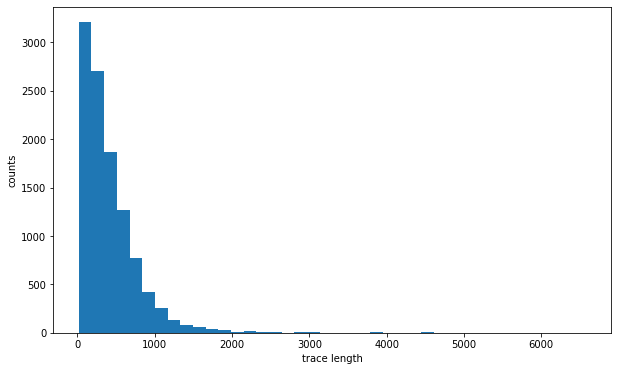

In [ ]:
print(np.max(trace_lengths))
print(np.argmax(trace_lengths))
plt.figure(figsize=(10,6))
plt.hist(trace_lengths, bins=40)
plt.ylabel('counts')
plt.xlabel('trace length')
#plt.savefig('./figures/trace_lengths.jpg')

In [ ]:
trace_lengths = np.array(trace_lengths)

n = (trace_lengths > 2000).sum()

print(n)
print(n/len(trace_lengths))

83
0.007587530852911601


### Cutoff expressoins where traces have length > 2000

In [ ]:
def cutoff_traces(dataset, max_len):
    '''Remove samples from X an y where y has a token length > 150.'''
    traces, images, tokens = dataset[0], dataset[1], dataset[2]
    
    trace_lengths = []
    for sample, trace in enumerate(traces):
        x, y = [], []
        for i in range(len(trace[0])):
            x.extend(trace[0][i])
            y.extend(trace[1][i])

        assert len(x)==len(y)
        trace_lengths.append(len(x))
        
    trace_lengths = np.array(trace_lengths)
    to_keep = list(np.where(trace_lengths > max_len)[0])
    removed = []
    for idx in reversed(to_keep):
#         print(idx)
        removed.append([dataset[i].pop(idx) for i in range(4)])
    return removed
                           
rem = cutoff_traces(dataset, max_len=2000)

In [ ]:
len(rem)

83

In [ ]:
traces, images, tokens = dataset[0], dataset[1], dataset[2]

In [ ]:
len(traces)

10856

### Cutoff tokens longer than length 150

Like mentioned in the paper (A Visual Latex Decompiler), we remove training samples with tokens longer than 150. However, we leave them in for testing.

We would thus remove 23 samples from the training set.

482
7218


Text(0.5, 0, 'token length')

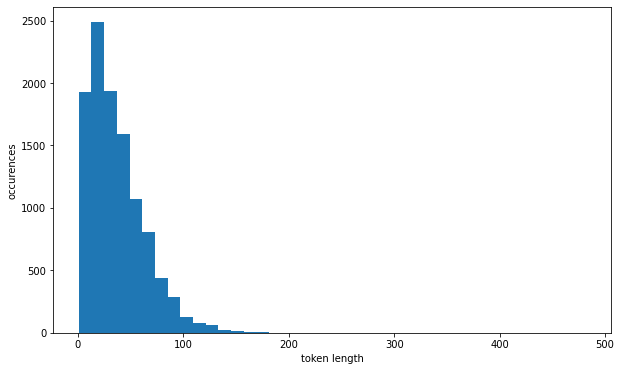

In [ ]:
L = []

for tok in tokens:
    L.append(len(tok))
    
print(np.max(L))
print(np.argmax(L))
plt.figure(figsize=(10,6))
plt.hist(L, bins=40)
plt.ylabel('occurences')
plt.xlabel('token length')
#plt.savefig('./figures/token_lengths.jpg')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(traces, tokens, test_size=1/4)

X_train = X_train[:100]
X_test = X_test[:100]
y_train = y_train[:100]
y_test = y_test[:100]

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

100
100
100
100


In [ ]:
def cutoff(X, y, token_length):
    '''Remove samples from X an y where y has a token length > 150.'''
    removed = []
    for idx in reversed(range(len(y))):
        if len(y[idx]) > token_length:
            print(idx)
            removed.append((X.pop(idx), y.pop(idx)))
    return removed
                           
rem = cutoff(X_train, y_train, token_length=150)

In [ ]:
len(X_train)

100

## Load vocabulary (unique LaTex tokens)

In [ ]:
from encode import train_label_encoding, OneHotEncoder

# load vocabulary
DATA = '/content/drive/MyDrive/'

vocab = np.load(DATA + 'labelencoding.npy')
label_enc = train_label_encoding(vocab)

## Torch Dataset object

### Function for processing traces:

* Pad to len 2000 with fill-forward
* Log scale

In [ ]:
def process_trace(trace: np.ndarray,  skip_t=10, pad_len=200, fill='last', scale=True) -> np.ndarray:
    x, y = [], []
    timechannel = []
    current_t = 0
    for i in range(len(trace[0])):
        x.extend(trace[0][i])
        y.extend(trace[1][i])
        current_segment_times = np.arange(len(trace[0][i])).astype(float)
        timechannel.extend(current_t + current_segment_times)
        current_t = current_t + skip_t + current_segment_times[-1]
    
    # Normalize time channel
    timechannel = np.array(timechannel)
    timechannel /= timechannel.max()
    
    # Log Scale 
    if scale==True:
        x = torch.tensor(x).log()
        y = torch.tensor(y).log()        
    
    # Append time channel
    unpadded = torch.tensor([timechannel, x, y]) 
    
    # Uniformly sample min(pad_len, trace_len) elements
    unpadded_len = unpadded.shape[1]
    sample_n_points = np.min([unpadded_len, pad_len])
    mask = torch.zeros(unpadded_len, dtype=int)
    mask[:sample_n_points] = 1
    mask = mask[torch.randperm(len(mask))]
    unpadded = unpadded[:,mask.to(torch.bool)]
          
    if unpadded.shape[1] < pad_len:
        # Padding
        if fill=='nan':
            pad = torch.full((3, pad_len-unpadded.shape[1]), float('nan'))
        elif fill=='last':
            pad = unpadded[:,-1].unsqueeze(1).expand(-1, pad_len - unpadded.shape[1])
        else: raise ValueError()        
        return torch.cat([unpadded,pad], dim=1).T
    else:
        return unpadded.T
    
trace_tensor = process_trace(traces[2], skip_t=10, pad_len=200, scale=True)
print(trace_tensor.shape)
# print(trace_tensor)

torch.Size([200, 3])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


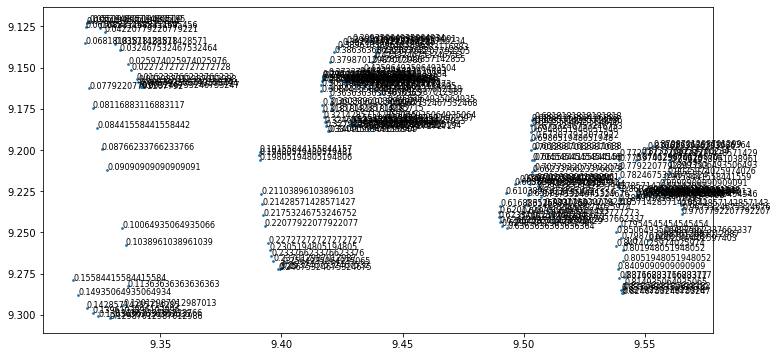

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(trace_tensor.T[1], trace_tensor.T[2], s=3)

for i in range(trace_tensor.T.shape[1]):
    x, y = trace_tensor.T[1, i], trace_tensor.T[2, i]
    plt.annotate(trace_tensor.T[0, i].item(), (x, y), fontsize=8)
plt.gca().invert_yaxis()
# plt.savefig('timechannel.jpg')

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

# input_shape=(250, 490)

transform = process_trace

target_transform = OneHotEncoder(label_enc)

class TraceTokenDataset(Dataset):
    def __init__(self, traces, tokens, transform=transform, target_transform=target_transform, vocab=vocab):
        self.traces = traces
        self.tokens = tokens
        self.transform = transform
        self.target_transform = target_transform
        self.vocab = vocab

    def __len__(self):
        return len(self.traces)

    def __getitem__(self, idx):
        trace = self.traces[idx]
        target = self.tokens[idx]
        if self.transform:
            trace = self.transform(trace)
        if self.target_transform:
            target = self.target_transform(target)
        return trace, target
    
    
train_data = TraceTokenDataset(X_train, y_train, transform=transform, target_transform=target_transform, vocab=vocab)
    
test_data = TraceTokenDataset(X_test, y_test, transform=transform, target_transform=target_transform, vocab=vocab)

In [ ]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, activation_function="relu"):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, input_channels * hidden_channels)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        if activation_function == 'sigmoid':
            self.activation_function = F.sigmoid
        elif activation_function == 'tanh':
            self.activation_function = F.tanh
        elif activation_function == 'relu':
            self.activation_function = F.relu
        

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = self.dropout1(z)
        z = self.linear2(z)
        z = self.dropout2(z)
        z = self.activation_function(z)
        z = self.linear3(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        # z = z.tanh()
        # print(z.shape)
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

In [ ]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial1 = torch.nn.Linear(input_channels, 128)
        self.initial2 = torch.nn.Linear(128, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial1(X0)
        z0 = self.dropout(z0)
        z0 = self.initial2(z0)
        # print(X0.shape)

        ######################
        # Actually solve the CDE.
        ######################
        # print(X.interval, X0.shape, z0.shape)
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        # print(z_T.shape)
        z_T = z_T[:, 0]
        pred_y = self.readout(z_T)
        return pred_y

In [ ]:
def test_batch(model, batch, device, threshold=0.5):
      
    coeffs, labels = batch[0].to(device), batch[1].to(device)
    outputs = torch.sigmoid(model(coeffs)).squeeze(-1).to('cpu')
    
    #print(np.where(y == 1))
#     correct, total = [], []
    P, R = [], []
    
    for sample in range(len(outputs.cpu())):
        pred_pos = set(np.where(outputs[sample].cpu()>=threshold)[0])
        pred_neg = set(np.where(outputs[sample].cpu()<threshold)[0])
        actual_pos = set(np.where(labels[sample].cpu()==1)[0])
        actual_neg = set(np.where(labels[sample].cpu()==0)[0])
        if len(actual_pos) < 1:
            continue
        TP = len(pred_pos & actual_pos)
        FP = len(pred_pos & actual_neg)
        TN = len(pred_neg & actual_neg)
        FN = len(pred_neg & actual_pos)
        precision = TP/(TP+FP) if TP+FP > 0 else 0
        recall = TP/(TP+FN) if TP+FN > 0 else 0
        P.append(precision)
        R.append(recall)

    P, R = np.array(P), np.array(R)
    return [P.mean(), P.std(), R.mean(), R.std()]

    
    
def test(model, testloader, threshold=0.5):
    device = torch.device("cpu")

    for d in testloader:
        test_x = d[0].float().to(device)
        test_y = d[1].float().to(device)
    
    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_x).to(device)
    test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128)
    
    with torch.no_grad():
    
        for batch in test_dataloader:
            print(test_batch(model, batch, device))
#             batch_coeffs, batch_y = batch[0].to(device), batch[1].to(device)
            
#             outputs = torch.sigmoid(model(batch_coeffs)).squeeze(-1).to('cpu')
    
#             print(outputs.shape)
#             print(outputs[0])
#             print(outputs[0][np.where(batch_y[0] == 1)] )
            break
#     correct = []
#     total = []
    
#     with torch.no_grad():
#         for idx, data in enumerate(testloader):
#             inputs, labels = data[0].float().to(device), data[1].float().to(device)
#             outputs = model(inputs)
            
#             for sample in range(len(outputs.cpu())):
#                 preds = np.where(outputs[sample].cpu()>threshold)[0]
#                 labels_ = np.where(labels[sample].cpu()==1)[0]
#                 if len(labels_) < 1:
#                     continue
#                 intersection = set(preds) & set(labels_)
#                 total.append(len(labels_))
#                 correct.append(len(intersection))
#         return np.array(correct), np.array(total)

In [ ]:
# Get whole processed dataset in order to compute interpolation coefficients
trainloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
testloader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [ ]:
vocab_len = 126
num_epochs = 1
batch_size = 100
log_every_n_batch=1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )
#     device = torch.device('cpu')
print(device)
for d in trainloader:
    train_x = d[0].float().to(device)
    train_y = d[1].float().to(device)

######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.
######################
model_config = {
    'input_channels': 3,
    'hidden_channels': 100,
    'output_channels': vocab_len,
    'lr': 1e-4,
    'save_dir': './model/eps/',
    'step': 0,
    'eps': 1e-8,
}

model = NeuralCDE(
    input_channels=model_config['input_channels'], hidden_channels=model_config['hidden_channels'], 
    output_channels=model_config['output_channels']
    )
model.to(device)
#print(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=model_config['lr'], eps=model_config['eps'])




cuda:0


In [ ]:
def save_model(model, step, config):
    """
    Save the trained model
    """
    save_dir = config['save_dir']
    step = config['step'] + step
    path = os.path.join(save_dir, '{}.ckpt'.format(step+1))

    torch.save(model.state_dict(), path)
    
    print('Saved model checkpoint as {}...'.format(path))


In [ ]:
# save_model(model, 0, model_config)

In [ ]:
def restore_model(config, device=None):
    """
    Restore the trained model.
    """
    step = config['step']
    print('Loading the trained models from step {}...'.format(step))
    path = os.path.join(config['save_dir'], '{}.ckpt'.format(step))

    model = NeuralCDE(input_channels=3, hidden_channels=model_config['hidden_channels'], output_channels=model_config['output_channels'])
        
    model.load_state_dict(torch.load(path))
    
    if device:
        model = model.to(device)

    return model

In [ ]:
# model = restore_model(model_config, device=device)

In [ ]:
np.random.seed(0)

In [ ]:
######################
# Now we turn our dataset into a continuous path. We do this here via Hermite cubic spline interpolation.
# The resulting `train_coeffs` is a tensor describing the path.
# For most problems, it's probably easiest to save this tensor and treat it as the dataset.
######################
#     criterion = nn.BCELoss()
criterion = torch.nn.functional.binary_cross_entropy_with_logits

train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_x)
train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
losses = []
print('Start training...')

optimizer.zero_grad()

with torch.autograd.set_detect_anomaly(True):

    for epoch in range(num_epochs):
        for i, batch in enumerate(train_dataloader):
            batch_coeffs, batch_y = batch
            batch_coeffs = batch_coeffs.to(device)
            batch_y = batch_y.to(device)
    #         print('forward pass')
            pred_y = model(batch_coeffs).squeeze(-1)
            if pred_y.isnan().any():
                print(pred_y.min())
                pred_y = torch.nan_to_num(pred_y)
                pred_y = pred_y.clamp(min=0)
                print(pred_y.min())
    #         print('finished forward pass')
            loss = criterion(pred_y, batch_y)
    #         print('backprop')
            loss.backward()
    #         print('finished backprop')
            optimizer.step()
    #         print('update')


            #==================#
            #    Tensorboard   #
            #==================#

    #         writer.add_scalar('train loss', loss)

            for name, param in model.named_parameters():
                print(name, param.grad.norm(), param.data.norm())
    #             writer.add_histogram(f'gradient {name}', param.grad, i)
    #             writer.add_histogram(f'weight   {name}', param.data, i)

            optimizer.zero_grad()
            losses.append(loss)

            if i % log_every_n_batch == 0:
                print('Batch: {}   Training loss: {}'.format(i, loss.item()))
                p_m, p_s, r_m, r_s = test_batch(model, batch, device)
                print(f'Precision: {100*p_m:.2f} +/- {100*p_s:.1f} %')
                print(f'Recall: {100*r_m:.2f} +/- {100*r_s:.1f} %')
                save_model(model, i, model_config)
    #         writer.flush()
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))
    print('Finished Training')


Start training...
func.linear1.weight tensor(0., device='cuda:0') tensor(6.5028, device='cuda:0')
func.linear1.bias tensor(0., device='cuda:0') tensor(0.6409, device='cuda:0')
func.linear2.weight tensor(0., device='cuda:0') tensor(9.2284, device='cuda:0')
func.linear2.bias tensor(0., device='cuda:0') tensor(0.8249, device='cuda:0')
func.linear3.weight tensor(0., device='cuda:0') tensor(10.0083, device='cuda:0')
func.linear3.bias tensor(0., device='cuda:0') tensor(0.6091, device='cuda:0')
initial1.weight tensor(0.2251, device='cuda:0') tensor(6.6477, device='cuda:0')
initial1.bias tensor(0.0188, device='cuda:0') tensor(3.5284, device='cuda:0')
initial2.weight tensor(1.1554, device='cuda:0') tensor(5.7700, device='cuda:0')
initial2.bias tensor(0.0267, device='cuda:0') tensor(0.5377, device='cuda:0')
readout.weight tensor(0.9146, device='cuda:0') tensor(6.5190, device='cuda:0')
readout.bias tensor(0.0425, device='cuda:0') tensor(0.6440, device='cuda:0')
Batch: 0   Training loss: 0.9843817

In [ ]:
train_coeffs.shape

torch.Size([100, 199, 12])

In [ ]:
c = train_coeffs[0]
c

tensor([[ 0.0000e+00,  8.9707e+00,  9.0230e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.4364e-03,  8.9707e+00,  9.0140e+00,  ...,  0.0000e+00,
         -1.9054e-03, -3.0613e-03],
        [ 6.8729e-03,  8.9713e+00,  9.0059e+00,  ...,  1.3970e-09,
          3.0470e-03,  9.3555e-04],
        ...,
        [ 9.8625e-01,  9.5186e+00,  8.5184e+00,  ..., -1.7881e-07,
         -8.8120e-04, -2.0599e-03],
        [ 9.8969e-01,  9.5185e+00,  8.5293e+00,  ..., -1.0309e-02,
         -2.2030e-04, -2.6496e-02],
        [ 9.9656e-01,  9.5184e+00,  8.5491e+00,  ...,  1.0309e-02,
         -1.3218e-03,  3.5542e-02]], device='cuda:0')

In [ ]:
c.shape

torch.Size([199, 12])

(array([  10., 1932.,   48.,    0.,    0.,    0.,    0.,    0.,    0.,
         398.]),
 array([-1.4488525 , -0.35186177,  0.745129  ,  1.8421198 ,  2.9391105 ,
         4.0361013 ,  5.133092  ,  6.230083  ,  7.3270736 ,  8.424065  ,
         9.521055  ], dtype=float32),
 <a list of 10 Patch objects>)

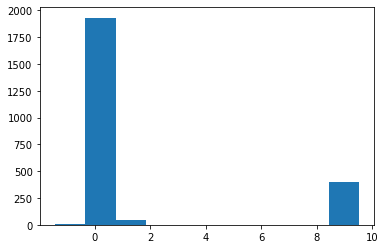

In [ ]:
plt.hist(c.cpu().ravel(), bins=10)

In [ ]:
c.min()

tensor(-1.4489, device='cuda:0')

In [ ]:
c.max()

tensor(9.5211, device='cuda:0')

In [ ]:
c.unique(return_counts=True)[1].shape

torch.Size([1765])

In [ ]:
0.0053 * model_config['lr']

5.3e-07

In [ ]:
writer.close()


In [ ]:
for name, param in model.named_parameters():
    print(name, param.data.norm())

func.linear1.weight tensor(6.6265, device='cuda:0')
func.linear1.bias tensor(0.3703, device='cuda:0')
func.linear2.weight tensor(15.9913, device='cuda:0')
func.linear2.bias tensor(1.4120, device='cuda:0')
initial.weight tensor(9.3351, device='cuda:0')
initial.bias tensor(5.6603, device='cuda:0')
readout.weight tensor(6.5246, device='cuda:0')
readout.bias tensor(0.4090, device='cuda:0')


In [ ]:
for name, param in model.func.named_parameters():
    print(name, param.data.norm())

linear1.weight tensor(6.6265, device='cuda:0')
linear1.bias tensor(0.3703, device='cuda:0')
linear2.weight tensor(15.9913, device='cuda:0')
linear2.bias tensor(1.4120, device='cuda:0')


In [ ]:
test(model.cpu(), testloader)

[0.07493699268884355, 0.042818498896016126, 0.5223782192743831, 0.211770656656533]


In [ ]:
X0, X1 = [], []
Y0, Y1 = [], []


for d in trainloader:
    traces = d[0]
    xmax = traces[:,:,1].max(1)[0]
    xmin = traces[:,:,1].min(1)[0]
    ymax = traces[:,:,2].max(1)[0]
    ymin = traces[:,:,2].min(1)[0]


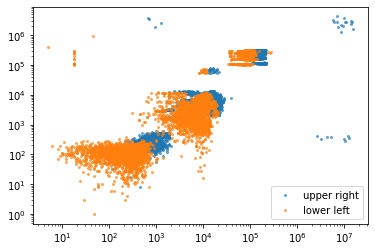

In [ ]:
plt.scatter(xmax, ymax, s=4, alpha=0.6, label='upper right')
plt.scatter(xmin, ymin, s=4, alpha=0.6, label='lower left')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('x_y_log_scale.jpg')

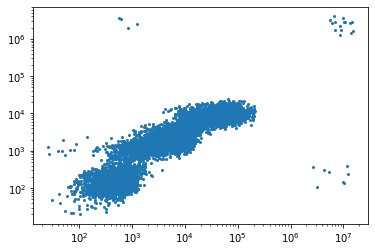

In [ ]:
plt.scatter(xmax-xmin, ymax-ymin, s=4)

plt.xscale('log')
plt.yscale('log')
# plt.legend()

In [ ]:
xmax.argmax()

tensor(3698)

In [ ]:
print(xmax[3698])
xmin[3698]

tensor(14961021., dtype=torch.float64)


tensor(24., dtype=torch.float64)

In [ ]:
torch.device('cuda:0')

device(type='cuda', index=0)